### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
import scipy.stats as sts 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
import matplotlib.cbook
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
from tqdm import tqdm
from scipy.stats import ttest_1samp
import random

%load_ext autoreload
%autoreload 2


from scikits import bootstrap
from sklearn.linear_model import LogisticRegression as lreg
from sklearn.linear_model import Ridge 
from sklearn.model_selection import cross_val_score,LeaveOneOut,KFold
from sklearn.metrics import accuracy_score,f1_score,r2_score
from sklearn.metrics import accuracy_score


sns.set_context("talk", font_scale=0.9)
sns.set_style({"ytick.direction": "in"})
sns.set_style({"xtick.direction": "in"})

### helpers

In [2]:
                
def normalize_vec(v):
    return v / np.linalg.norm(v)
    

def gram_schmidt_1(v,vecs):
    v = v.copy()
    for i in range(len(vecs)):
        v1 = normalize_vec(vecs[i])
        v = v - (v @ v1) * v1
    return v

def angle_v(vector_1, vector_2):
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.degrees(np.arccos(dot_product))
    return angle


def plot_traj(x,y,color='gray',size=1):

    plt.plot(x,y,color=color,lw=3)
    # plot line from -2 to -1 point
    plt.arrow(x[-2],y[-2],x[-1] - x[-2],y[-1] - y[-2],head_width=size*0.075,color=color,lw=1)
    plt.plot(x[4],y[4],"o",color=color,ms=10)


### load data

In [3]:
### raw dataframe
df_A1 = pd.read_csv("Data/RW_dataframe_A1_nozscore_smooth.csv")
df_PFC = pd.read_csv("Data/RW_dataframe_PFC_nozscore_smooth.csv")

### regression decoding
f = open("Data/decoders/pseudo_regression_A1_PFC_dec.pickle","rb")
all_decs = pickle.load(f)

f = open("Data/decoders/pseudo_regression_A1_PFC_dec_shuffle.pickle","rb")
all_decs_shuffle = pickle.load(f)

### across-context decoding
f = open("Data/decoders/pseudo_cross_A1_dec_fixed.pickle",'rb')
all_decs_A1 = pickle.load(f)

f = open("Data/decoders/pseudo_cross_PFC_dec_fixed.pickle",'rb')
all_decs_PFC = pickle.load(f)

f = open("Data/decoders/pseudo_cross_A1_dec_weights.pickle","rb")
coef_A1 = pickle.load(f)

f = open("Data/decoders/pseudo_cross_PFC_dec_weights.pickle","rb")
coef_PFC = pickle.load(f)


### definitions
time = np.loadtxt("Data/time.txt")
stim_idx = (time>=0) & (time<=0.25)
rel_color = "#eba071"


area = 'A1'

if area == 'A1':
    cross_coef = coef_A1[:,0]
    same_coef = coef_A1[:,1]
    cross_decs = all_decs_A1[:,0]
    same_decs = all_decs_A1[:,1]
    df_area = df_A1
else:
    cross_coef = coef_PFC[:,0]
    same_coef = coef_PFC[:,1]
    cross_decs = all_decs_PFC[:,0]
    same_decs = all_decs_PFC[:,1]
    df_area = df_PFC

### average decoding

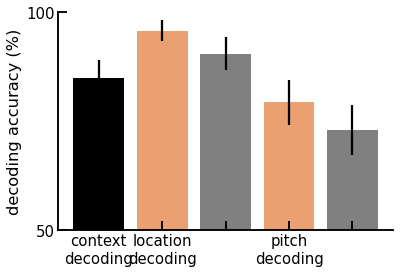

In [4]:
loc_rel = np.mean(all_decs[0,:,0,0,11:],1)
pitch_rel = np.mean(all_decs[0,:,1,1,11:],1)

loc_irel = np.mean(all_decs[0,:,0,1,11:],1)
pitch_irel = np.mean(all_decs[0,:,1,0,11:],1)

context_dec = np.mean(all_decs[0,:,2,1,11:],1)

plt.bar([0,1,2,3,4],[np.mean(context_dec),np.mean(loc_rel),np.mean(loc_irel),np.mean(pitch_rel),np.mean(pitch_irel)],
        color=['black',rel_color,'gray',rel_color,'gray'])
plt.errorbar([0,1,2,3,4],[np.mean(context_dec),np.mean(loc_rel),np.mean(loc_irel),np.mean(pitch_rel),np.mean(pitch_irel)],
            [2*np.std(context_dec),2*np.std(loc_rel),2*np.std(loc_irel),2*np.std(pitch_rel),2*np.std(pitch_irel)],color='black',fmt='None')

plt.xticks([0,1,2,3,4],['context\ndecoding','location\ndecoding','','pitch\ndecoding',''])
plt.ylim(0.5,1)
plt.yticks([0.5,1],[50,100])
plt.ylabel('decoding accuracy (%)')
sns.despine()

# plt.savefig("figures/paper/Fig1_decoding_vars.svg")


## calculate sensory and decision axis

In [5]:
n_folds = 500

irrelevant_axis_location = np.mean(same_coef[0,1][:,11:16],1)
relevant_axis_location = np.mean(same_coef[0,0][:,11:16],1)
decision_axis_location = np.mean(same_coef[0,0][:,17:],1)

orth_axis_location = np.array([gram_schmidt_1(relevant_axis_location[i],[irrelevant_axis_location[i]]) for i in range(n_folds)])
irrelevant_axis_location = np.array([gram_schmidt_1(irrelevant_axis_location[i],[decision_axis_location[i]]) for i in range(n_folds)])

irrelevant_axis_pitch = np.mean(same_coef[1,0][:,11:16],1)
relevant_axis_pitch = np.mean(same_coef[1,1][:,11:16],1)
decision_axis_pitch = np.mean(same_coef[1,1][:,17:],1)

orth_axis_pitch = np.array([gram_schmidt_1(relevant_axis_pitch[i],[irrelevant_axis_pitch[i]])  for i in range(n_folds)])
irrelevant_axis_pitch = np.array([gram_schmidt_1(irrelevant_axis_pitch[i],[decision_axis_pitch[i]])  for i in range(n_folds)])

dict_projections = {}

for k, stim_df in df_area.groupby("stims"):
    dict_projections[k] = []
    avg_by_neuron = stim_df.groupby('neuron_id').mean().reset_index()
    spcounts_by_time = avg_by_neuron.values[:,-40:][:,15:25] /0.05 # in hz

    #spcounts_by_time -= np.mean(spcounts_by_time[:,:5],1)[:,None]
    #spcounts_by_time, spcounts_test_same,labels_train_same,labels_test_same = df_train_test_split(stim_df,"stims",10)
    #spcounts_by_time = spcounts_by_time[:,:,15:24] # bin size in sec

    dict_projections[k].append(spcounts_by_time.T @ normalize_vec(irrelevant_axis_location.T))

    dict_projections[k].append(spcounts_by_time.T @ normalize_vec(orth_axis_location.T))


    dict_projections[k].append(spcounts_by_time.T @ normalize_vec(irrelevant_axis_pitch.T))

    dict_projections[k].append(spcounts_by_time.T @ normalize_vec(orth_axis_pitch.T))

    dict_projections[k] = np.array(dict_projections[k])


Text(0, 0.5, 'degrees $(\\circ)$')

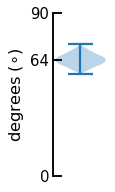

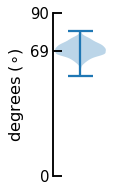

In [6]:

angles_location = [angle_v(irrelevant_axis_location[f], relevant_axis_location[f]) for f in range(n_folds)]
angles_pitch = [angle_v(irrelevant_axis_pitch[f], relevant_axis_pitch[f]) for f in range(n_folds)]

plt.figure(figsize=(1,3))
plt.violinplot(angles_location)
plt.ylim(0,90)
plt.yticks([0,int(np.mean(angles_location)),90])
sns.despine(bottom=True)
plt.xticks([])
plt.ylabel('degrees 'r'$(\circ)$')
# plt.savefig('figures/paper/angles_location.svg')

plt.figure(figsize=(1,3))
plt.violinplot(angles_pitch)
plt.ylim(0,90)
plt.yticks([0,int(np.mean(angles_pitch)),90])
sns.despine(bottom=True)
plt.xticks([])
plt.ylabel('degrees 'r'$(\circ)$')
# plt.savefig('figures/paper/angles_pitch.svg')

In [7]:


# go - no-go, relevant
location_difference_relevant_1 = (dict_projections['ri_lo_lc'] - dict_projections['le_lo_lc'])
location_difference_relevant_2 = (dict_projections['ri_hi_lc'] - dict_projections['le_hi_lc'])
location_difference_relevant = location_difference_relevant_1/2 + location_difference_relevant_2/2

# go - no-go, irrelevant
location_difference_irrelevant_1 = (dict_projections['ri_lo_pc'] - dict_projections['le_lo_pc'])
location_difference_irrelevant_2 = (dict_projections['ri_hi_pc'] - dict_projections['le_hi_pc'])
location_difference_irrelevant = location_difference_irrelevant_1/2 + location_difference_irrelevant_2/2

# same for pitch context
pitch_difference_relevant_1 = (dict_projections['le_hi_pc'] - dict_projections['le_lo_pc']) 
pitch_difference_relevant_2 = (dict_projections['ri_hi_pc'] - dict_projections['ri_lo_pc'])
pitch_difference_relevant = pitch_difference_relevant_1/2 + pitch_difference_relevant_2/2

pitch_difference_irrelevant_1 = (dict_projections['le_hi_lc'] - dict_projections['le_lo_lc'])
pitch_difference_irrelevant_2 = (dict_projections['ri_hi_lc'] - dict_projections['ri_lo_lc'])
pitch_difference_irrelevant = pitch_difference_irrelevant_1/2 + pitch_difference_irrelevant_2/2




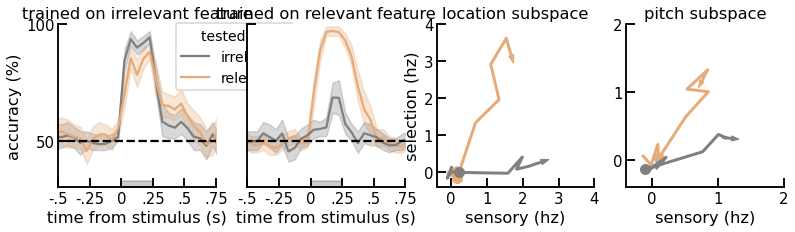

In [8]:
plt.figure(figsize=(13,3))

plt.subplot(1,4,1)
plt.title('trained on irrelevant feature')

err_bars = np.array([np.percentile(a,[18,84]) for a in same_decs[0,1,:].T])
plt.fill_between(time[9:39],err_bars[:,0],err_bars[:,1],color="gray",alpha=0.3)
plt.plot(time[9:39],np.mean(same_decs,2)[0,1],color='gray',label='irrelevant')

err_bars = np.array([np.percentile(a,[18,84]) for a in cross_decs[0,1,:].T])
plt.fill_between(time[9:39],err_bars[:,0],err_bars[:,1],color="#e7ab79",alpha=0.3)
plt.plot(time[9:39],np.mean(cross_decs,2)[0,1],color='#e7ab79',label='relevant')
plt.plot(time[9:39],np.ones(30)*0.5,'k--')
plt.fill_between([0,.25],[0.3,0.30],[.325,.325],color="black",alpha=0.2)

plt.xlim(-0.5,0.75)
plt.ylim(0.3,1)
plt.yticks([0.5,1],[50,100])
plt.ylabel('accuracy (%)')
plt.xticks([-.5,-0.25,0,0.25,0.5,0.75],['-.5','-.25','0','.25','.5','.75'])
plt.legend(bbox_to_anchor=(0.7, 1.05),fontsize=14,title='tested on',title_fontsize=14)
plt.xlabel('time from stimulus (s)')
sns.despine()

plt.subplot(1,4,2)
plt.title('trained on relevant feature')
err_bars = np.array([np.percentile(a,[18,84]) for a in same_decs[0,0,:].T])
plt.fill_between(time[9:39],err_bars[:,0],err_bars[:,1],color="#e7ab79",alpha=0.3)
plt.plot(time[9:39],np.mean(same_decs,2)[0,0],color='#e7ab79',label='relevant')

err_bars = np.array([np.percentile(a,[18,84]) for a in cross_decs[0,0,:].T])
plt.fill_between(time[9:39],err_bars[:,0],err_bars[:,1],color="gray",alpha=0.3)
plt.plot(time[9:39],np.mean(cross_decs,2)[0,0],color='gray',label='irrelevant')

plt.plot(time[9:39],np.ones(30)*0.5,'k--')
plt.fill_between([0,.25],[0.3,0.30],[.325,.325],color="black",alpha=0.2)

plt.xlim(-0.5,0.75)
plt.ylim(0.3,1)
plt.yticks([0.5,1],[])
plt.xticks([-.5,-0.25,0,0.25,0.5,0.75],['-.5','-.25','0','.25','.5','.75'])
plt.xlabel('time from stimulus (s)')
plt.ylim(0.3,1)
plt.yticks([0.5,1],[])


plt.subplot(1,4,3)


plt.title("location subspace")

## average pairs difference, then plot
x1,y1 = np.mean(location_difference_relevant_1[0],1),np.mean(location_difference_relevant_1[1],1)
x2, y2 = np.mean(location_difference_relevant_2[0],1),np.mean(location_difference_relevant_2[1],1)

x = x1/2 + x2/2
y = y1/2 + y2/2

plot_traj(x,y,'#e7ab79',size=2)

x1,y1 = np.mean(location_difference_irrelevant_1[0],1),np.mean(location_difference_irrelevant_1[1],1)
x2,y2 = np.mean(location_difference_irrelevant_2[0],1),np.mean(location_difference_irrelevant_2[1],1)

x = x1/2 + x2/2
y = y1/2 + y2/2
plot_traj(x,y,'gray',size=2)


plt.xlabel('sensory (hz)')
plt.ylabel("selection (hz)")

plt.ylim(-0.4,2)
plt.xlim(-0.4,2)
plt.yticks(range(0,5))
plt.xticks(range(0,5))


plt.subplot(1,4,4)
plt.title("pitch subspace")

x1,y1 = np.mean(-pitch_difference_relevant_1[2],1),np.mean(-pitch_difference_relevant_1[3],1)
x2, y2 = np.mean(-pitch_difference_relevant_2[2],1),np.mean(-pitch_difference_relevant_2[3],1)

x = x1/2 + x2/2
y = y1/2 + y2/2

plot_traj(x,y,'#e7ab79')

x1,y1 = np.mean(-pitch_difference_irrelevant_1[2],1),np.mean(-pitch_difference_irrelevant_1[3],1)
x2,y2 = np.mean(-pitch_difference_irrelevant_2[2],1),np.mean(-pitch_difference_irrelevant_2[3],1)

x = x1/2 + x2/2
y = y1/2 + y2/2

plot_traj(x,y,'gray')


plt.xlabel('sensory (hz)')

plt.ylim(-0.4,2)
plt.xlim(-0.4,2)
plt.yticks(range(0,3))
plt.xticks(range(0,3))

sns.despine()


sns.despine()
#plt.tight_layout()
plt.savefig('../Fig1_%s_pitch.svg' % area)